In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
os.chdir("../data")
conn = sqlite3.connect('congress.db')
# congress = pd.read_sql_query("SELECT * FROM congress WHERE congress=115", conn)
congress = pd.read_sql_query("SELECT * FROM congress", conn)
conn.close()

In [3]:
df = congress.copy()

In [4]:
df

,congress,hr_measure,sponsor_name,sponsor_party,bill_name,bill_summary
0,117,1,Sarbanes John P,D,For the People Act of 2021,"This bill addresses voter access, election int..."
1,117,3,Pallone Frank Jr,D,Elijah E. Cummings Lower Drug Costs Now Act,This bill establishes several programs and req...
2,117,4,Sewell Terri A,D,John R. Lewis Voting Rights Advancement Act of...,This bill establishes new criteria for determi...
3,117,5,Cicilline David N,D,Equality Act,This bill prohibits discrimination based on se...
4,117,6,Roybal-Allard Lucille,D,None,American Dream and Promise Act of 2021 This bi...
...,...,...,...,...,...,...
19641,115,7397,Hoyer Steny H,D,None,DIVISION A--FURTHER ADDITIONAL CONTINUING APPR...
19642,115,7398,Foster Bill,D,Shutdown Prioritization Act or the SPA Act,This bill prohibits operation of an exercise f...
19643,115,7399,Scanlon Mary Gay,D,Inaugural Fund Integrity Act,This bill imposes various restrictions on pres...
19644,115,7400,Wild Susan,D,None,This bill provides FY2019 continuing appropria...


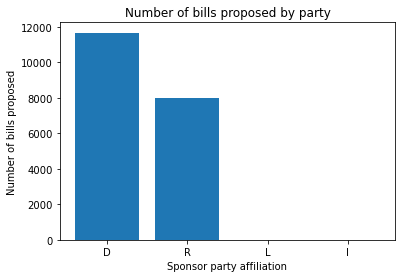

In [5]:
# Visualize proportion of bills by party
plt.title('Number of bills proposed by party')
plt.xlabel('Sponsor party affiliation')
plt.ylabel('Number of bills proposed')
plt.bar(df['sponsor_party'].value_counts().index.values,
        df['sponsor_party'].value_counts().values)
plt.show();

In [6]:
# Get bill count data
bill_count = df[['sponsor_name', 'congress']].groupby(['sponsor_name']).count()
bill_count.columns = ['num_bills']
bill_count = bill_count.reset_index()
bill_count = bill_count.merge(df[['sponsor_name', 'sponsor_party']], on='sponsor_name').drop_duplicates()
bill_count = bill_count.sort_values(by=['num_bills'], ascending=False)

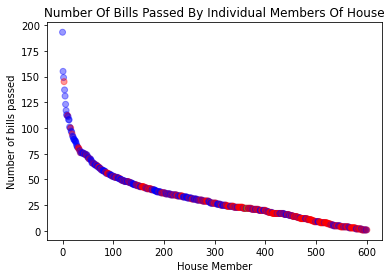

In [7]:
# Plot the number of bills passed by member, colored by party affiliation
plt.title('Number of bills passed by individual members of house'.title())
plt.xlabel('House Member')
plt.ylabel('Number of bills passed')
plt.scatter(np.arange(bill_count.shape[0]), bill_count['num_bills'],
        color=bill_count['sponsor_party'].map({'R': 'r', 'D': 'b', 'L': 'orange', 'I': 'g'}),
        alpha=0.4)
plt.show();

In [8]:
#reduce dataframe to just sponsor party and bill_summary
#Removing Ind and Lib bills

#input = "bill_summary"
#output = "sponsor_party"

col = ['sponsor_party', 'bill_summary']
df = df[col]
df = df[pd.notnull(df['bill_summary'])]
df = df[df.sponsor_party != 'I']
df = df[df.sponsor_party != 'L']
df.head()

,sponsor_party,bill_summary
0,D,"This bill addresses voter access, election int..."
1,D,This bill establishes several programs and req...
2,D,This bill establishes new criteria for determi...
3,D,This bill prohibits discrimination based on se...
4,D,American Dream and Promise Act of 2021 This bi...


In [9]:
#Add category IDs and sort
df['category_id'] = df['sponsor_party'].factorize()[0]
category_id_df = df[['sponsor_party', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'sponsor_party']].values)
df.head()

,sponsor_party,bill_summary,category_id
0,D,"This bill addresses voter access, election int...",0
1,D,This bill establishes several programs and req...,0
2,D,This bill establishes new criteria for determi...,0
3,D,This bill prohibits discrimination based on se...,0
4,D,American Dream and Promise Act of 2021 This bi...,0


In [10]:
#tf-idf (Term Frequency, Invervse Document Frequency)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.bill_summary).toarray()
labels = df.category_id
features.shape
#have 19637 bills with 49342 features each

(19637, 49328)

## Classifiers

In [11]:
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score


In [12]:
# Chi-squared stats
N = 2
for sponsor_party, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(sponsor_party))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))


# 'D':
  . Most correlated unigrams:
. grants
. sec
  . Most correlated bigrams:
. sec amends
. award grants
# 'R':
  . Most correlated unigrams:
. grants
. sec
  . Most correlated bigrams:
. sec amends
. award grants


### Bayes

In [10]:
# Model
X_train, X_test, y_train, y_test = train_test_split(df['bill_summary'], df['sponsor_party'])
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [11]:
# Bayes Prediction Testing
count_vect_v = CountVectorizer(vocabulary=count_vect.vocabulary_) #limit to vocab in training data set; prevent dimension mismatch
t = count_vect_v.transform(["American Dream and Promise Act of 2021 This bill provides certain aliens with a path to receive permanent resident status and contains other immigration-related provisions.The Department of Homeland Security (DHS) or the Department of Justice (DOJ) shall provide conditional permanent resident status for 10 years to a qualifying alien who entered the United States as a minor and (1) is deportable or inadmissible, (2) has deferred enforced departure (DED) status or temporary protected status (TPS), or (3) is the child of certain classes of nonimmigrants. The bill imposes various qualifying requirements, such as the alien being continuously physically present in the United States since January 1, 2021, passing a background check, and being enrolled in or having completed certain educational programs.DHS shall remove the conditions placed on permanent resident status granted under this bill if the alien applies and meets certain requirements, such as completing certain programs at an educational institution, serving in the military, or being employed.Furthermore, DHS and DOJ shall cancel the removal of certain aliens who had TPS, were eligible for TPS, or were eligible for DED status on certain dates. Such an alien shall receive permanent resident status upon meeting certain requirements and applying for such status within three years of this bill's enactment.For an alien seeking permanent resident status under this bill, DHS may (1) waive certain grounds of inadmissibility, or (2) provisionally deny the application if the alien poses a danger to public safety or has knowingly participated in certain offenses involving a criminal street gang. An alien shall have the right to administrative and judicial review of a denial or revocation of permanent resident status granted under this bill. An alien seeking judicial review of a provisional denial shall be appointed counsel upon request. An alien who appears to be prima facie eligible for relief under this bill shall receive a reasonable chance to apply for such relief and may not be removed until there is a final decision on that application for relief. DHS may not use information from applications filed under this bill or for Deferred Action for Childhood Arrivals status for immigration enforcement purposes. DHS shall establish a grant program for nonprofit organizations that assist individuals with certain immigration-related issues. This bill also repeals a restriction that bars a state from providing higher education benefits to undocumented aliens unless those benefits are available to all U.S. nationals without regard to residency in the state. An alien shall have the right to administrative and judicial review of a denial or revocation of permanent resident status granted under this bill. An alien seeking judicial review of a provisional denial shall be appointed counsel upon request. An alien who appears to be prima facie eligible for relief under this bill shall receive a reasonable chance to apply for such relief and may not be removed until there is a final decision on that application for relief. DHS may not use information from applications filed under this bill or for Deferred Action for Childhood Arrivals status for immigration enforcement purposes. DHS shall establish a grant program for nonprofit organizations that assist individuals with certain immigration-related issues. This bill also repeals a restriction that bars a state from providing higher education benefits to undocumented aliens unless those benefits are available to all U.S. nationals without regard to residency in the state. An alien who appears to be prima facie eligible for relief under this bill shall receive a reasonable chance to apply for such relief and may not be removed until there is a final decision on that application for relief. DHS may not use information from applications filed under this bill or for Deferred Action for Childhood Arrivals status for immigration enforcement purposes. DHS shall establish a grant program for nonprofit organizations that assist individuals with certain immigration-related issues. This bill also repeals a restriction that bars a state from providing higher education benefits to undocumented aliens unless those benefits are available to all U.S. nationals without regard to residency in the state. DHS may not use information from applications filed under this bill or for Deferred Action for Childhood Arrivals status for immigration enforcement purposes.DHS shall establish a grant program for nonprofit organizations that assist individuals with certain immigration-related issues.This bill also repeals a restriction that bars a state from providing higher education benefits to undocumented aliens unless those benefits are available to all U.S. nationals without regard to residency in the state. "])

print(clf.predict(t))

['D']


In [12]:
# Bayes Accuracy Testing - in progress
X_test_counts = count_vect_v.transform(X_test)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)

y_pred = clf.predict(X_test_tfidf)
print(metrics.accuracy_score(y_test,y_pred))

0.6778004073319756


### Model Testing

In [ ]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))


In [ ]:
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()
cv_df.groupby('model_name').accuracy.mean()

## Method 2/Data Cleaning

In [15]:
from sklearn.feature_extraction import text, _stop_words

In [16]:
#split data frame
dem = df.loc[df.sponsor_party=='D']
rep = df.loc[df.sponsor_party=='R']
ind = df.loc[df.sponsor_party=='I']
lib = df.loc[df.sponsor_party=='L']

In [17]:
def word_counter(title_df,stop_list = []):
    
    # Count Vectorize
    cvec = CountVectorizer(stop_words = stop_list)

    # Transform the corpus
    X_text = cvec.fit_transform(title_df['bill_summary'])

    # Converts text to array form
    X_text = pd.DataFrame(X_text.toarray(), columns= cvec.get_feature_names())

    # See word counts
    word_counts = X_text.sum().sort_values(0, ascending=False)
    
    return word_counts

In [18]:
# Check Fillers
fillers = _stop_words.ENGLISH_STOP_WORDS
dem_f_count = word_counter(dem)
dem_count = word_counter(dem, fillers)

rep_f_count = word_counter(rep)
rep_count = word_counter(rep, fillers)

ind_f_count = word_counter(ind)
ind_count = word_counter(ind, fillers)

lib_f_count = word_counter(lib)
lib_count = word_counter(lib, fillers)


## COME BACK - get common elements of series (compare), get rid of shared/common words; possibly makes more accurate?

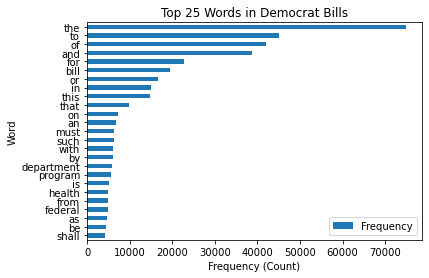

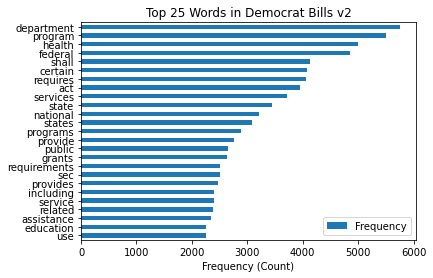

In [19]:
dems_wordcount = pd.DataFrame(word_counter(dem), columns=["Frequency"])
politics_top15 = dems_wordcount.head(25)
politics_top15.sort_values('Frequency',ascending=True).plot(kind = "barh")
plt.title("Top 25 Words in Democrat Bills")
plt.xlabel("Frequency (Count)")
plt.ylabel("Word")
plt.show()

dems_wordcount = pd.DataFrame(word_counter(dem, fillers), columns=["Frequency"])

# Visualization
politics_top15 = dems_wordcount.head(25)
politics_top15.sort_values('Frequency',ascending=True).plot(kind = "barh")
plt.title("Top 25 Words in Democrat Bills v2")
plt.xlabel("Frequency (Count)")
plt.show()

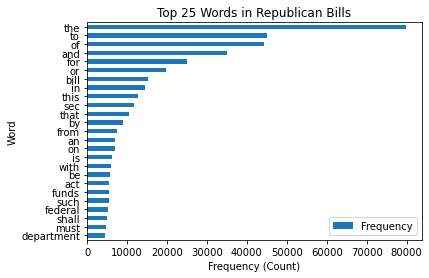

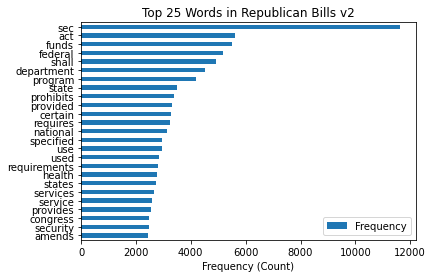

In [20]:
reps_wordcount = pd.DataFrame(word_counter(rep), columns=["Frequency"])
politics_top25 = reps_wordcount.head(25)
politics_top25.sort_values('Frequency',ascending=True).plot(kind = "barh")
plt.title("Top 25 Words in Republican Bills")
plt.xlabel("Frequency (Count)")
plt.ylabel("Word")
plt.show()

reps_wordcount = pd.DataFrame(word_counter(rep, fillers), columns=["Frequency"])

# Visualization
politics_top25 = reps_wordcount.head(25)
politics_top25.sort_values('Frequency',ascending=True).plot(kind = "barh")
plt.title("Top 25 Words in Republican Bills v2")
plt.xlabel("Frequency (Count)")
plt.show()

In [21]:
# adding in more common/shared words
additional_poli_stop = ['shall','certain','act','federal','requires','requirements','department']
all_stop = fillers.union(additional_poli_stop)
dem_count = word_counter(dem, all_stop)
rep_count = word_counter(rep, all_stop)
ind_count = word_counter(ind, all_stop)
lib_count = word_counter(lib, all_stop)
print(dem_count.head())

program     5505
health      4994
services    3710
state       3453
national    3202
dtype: int64


In [22]:
#tf-idf (Term Frequency, Invervse Document Frequency)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=all_stop)

features = tfidf.fit_transform(df.bill_summary).toarray()
labels = df.category_id
features.shape
#have 19646 bills with 47962 features each

(19646, 47962)

# Trying Out Different Analysis Methods

In [33]:
import pandas as pd
from sklearn.metrics import confusion_matrix
#from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score, confusion_matrix

### Bayes Take 2

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df['bill_summary'], df['sponsor_party'])
count_vect = CountVectorizer(stop_words = all_stop)
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [24]:
count_vect_v = CountVectorizer(vocabulary=count_vect.vocabulary_, stop_words=all_stop) #limit to vocab in training data set; prevent dimension mismatch

X_test_counts = count_vect_v.transform(X_test)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)

y_pred = clf.predict(X_test_tfidf)
print(metrics.accuracy_score(y_test,y_pred))

0.6750814332247557


### Count Vectorizor with Logistic Regression

In [59]:
pipe_cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

pipe_params_cvec_lr = {
    'cvec__max_features': [None,500,1000],
    'cvec__min_df': [2,3],
    'cvec__max_df': [.3,.4,],
    'cvec__ngram_range': [(1,2),(1,3)],
    'cvec__stop_words': [None,'english',all_stop],
    'lr__penalty': ['l2']
}

gs = GridSearchCV(pipe_cvec_lr, param_grid=pipe_params_cvec_lr, cv=5,n_jobs = -1,verbose = 1)

gs.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.3, 0.4],
                         'cvec__max_features': [None, 500, 1000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 2), (1, 3)],
                         'cvec__stop_words': [None, 'english',
                                              frozenset({'a', 'about', 'above',
                                                         'across', 'act',
                                                         'after', 'afterwards',
                                                         'again', 'against',
                                                         'all', 'almost',
                                                         'alone', 'along',
                                                         'alrea

In [61]:
cvlr_bestscore = gs.best_score_
cvlr_params = gs.best_params_
cvlr_train = gs.score(X_train,y_train)
cvlr_test= gs.score(X_test,y_test)
cvlr = ('CountVec with LogReg', cvlr_bestscore, cvlr_params, cvlr_train, cvlr_test)

In [62]:
print(f'Best CV Score: {gs.best_score_}')
print(f'Best Parameters: {gs.best_params_}')
print(f'Train Accuracy Score: {gs.score(X_train,y_train)}')
print(f'Test Accuracy Score: {gs.score(X_test,y_test)}')

Best CV Score: 0.751612880173629
Best Parameters: {'cvec__max_df': 0.4, 'cvec__max_features': None, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english', 'lr__penalty': 'l2'}
Train Accuracy Score: 0.9944998981462619
Test Accuracy Score: 0.7665987780040733


### TF-IDF with Logistic Regression

In [63]:
pipe_tvec_lr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

pipe_params_tvec_lr = {
    'tvec__max_features': [None,1000],
    'tvec__min_df': [2,3,4],
    'tvec__max_df': [.3,.5],
    'tvec__ngram_range': [(1,1),(1,3)],
    'tvec__stop_words': [None, all_stop,'english'],
    'lr__penalty': ['l2']
}

gs = GridSearchCV(pipe_tvec_lr, param_grid=pipe_params_tvec_lr, cv=4, n_jobs=-1, verbose = 1)

gs.fit(X_train,y_train)


print(f'Best Score: {gs.best_score_}')
print(f'Best Parameters: {gs.best_params_}')
print(f'Train Accuracy Score: {gs.score(X_train,y_train)}')
print(f'Test Accuracy Score: {gs.score(X_test,y_test)}')

Fitting 4 folds for each of 72 candidates, totalling 288 fits
Best Score: 0.72777878121292
Best Parameters: {'lr__penalty': 'l2', 'tvec__max_df': 0.3, 'tvec__max_features': None, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': None}
Train Accuracy Score: 0.8760100495688192
Test Accuracy Score: 0.7256619144602852


In [64]:
tflr_bestscore = gs.best_score_
tflr_params = gs.best_params_
tflr_train = gs.score(X_train,y_train)
tflr_test= gs.score(X_test,y_test)
tflr = ('TF-IDF with LogReg',tflr_bestscore, tflr_params, tflr_train, tflr_test)

In [65]:
print(f'Best Score: {gs.best_score_}')
print(f'Best Parameters: {gs.best_params_}')
print(f'Train Accuracy Score: {gs.score(X_train,y_train)}')
print(f'Test Accuracy Score: {gs.score(X_test,y_test)}')

Best Score: 0.72777878121292
Best Parameters: {'lr__penalty': 'l2', 'tvec__max_df': 0.3, 'tvec__max_features': None, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': None}
Train Accuracy Score: 0.8760100495688192
Test Accuracy Score: 0.7256619144602852


### Multinomial Bayes + Count Vectorizor

In [1]:
pipe_cvec_mnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

pipe_params_cvec_mnb = {
    'cvec__max_features': [None,500,1000,2500],
    'cvec__min_df': [2,3],
    'cvec__max_df': [.4, .8],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
    'cvec__stop_words': [None, new_stop_list,'english']
}

gs = GridSearchCV(pipe_cvec_mnb, param_grid=pipe_params_cvec_mnb, cv=4, n_jobs = 4, verbose = 1)

gs.fit(X_train['Post Text'],y_train)

NameError: name 'Pipeline' is not defined